# Introduction

## Data Source

* Please download your heart rate data from https://stila.pms.ifi.lmu.de
* Pick a day from the overview calendar, be aware that you don't pick an event
* Click the "Download HR data" button to download the heart rate data

## Packages
use pip3 to install the following package
```python
pip3 install numpy
pip3 install SciPy
pip3 install matplotlib
```

## Location of the heart rate raw data

For further analysis, please save the heart rate raw data in the **"dataSource"** directory

Please run the following cell to see your heart rate data

## Assignment 1 (Input Data)
* Download your heart rate data from https://stila.pms.ifi.lmu.de
* put the heartrate_2016-XX-XX.csv file in to the dataSource folder
* change the filename to your downloaded csv file

In [7]:
# enable matplotlib inline codes
#%matplotlib auto
%matplotlib notebook
#%matplotlib nbagg
#%matplotlib inline

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import datetime as dt




### Assignment 1
### Please only replace the filename with the name of your csv file
#filename = 'heartrate_2016-10-05.csv'
filename = 'heartrate_2016-10-27.csv'

### Don't change the following code in this cell.

# Get the current working directory
currentDir=os.getcwd()

heartRateFile = os.path.abspath(os.path.join(currentDir,'dataSource',filename))
if os.path.exists(heartRateFile):
    print('Oberserving HeartRateFile Path is:\n%s' %(heartRateFile))
else:
    raise Exception(
      'File %s \n does not exist!' %(heartRateFile)
    )

Oberserving HeartRateFile Path is:
C:\Users\Chrisi\Desktop\Studium\Seminar\dataSource\heartrate_2016-10-27.csv


In [9]:
def parseCSV(file, coding='utf-8'):
    # a possible encoding can be 'iso-8859-15'
    with open(file, 'r', encoding=coding) as csvfile:
        reader = csv.reader(csvfile)
        content = list(reader)
        header = content.pop(0) # remove first header
    return header, content

hrHeader, hrContent = parseCSV(heartRateFile, 'utf-8') # with default windows encoding

print(hrHeader)
print('The Format of single HR Data: ', hrContent[0])
print("Loaded No. of Heart Rate Raw Data is: %d" %(len(hrContent)))

# The timestamp in data sets are utc timestamps
hrRaw = [heartrate for timestamp, heartrate in hrContent]
timestampRaw = [dt.datetime.fromtimestamp(int(timestamp)/1000) for timestamp, heartrate in hrContent]

#print(len(hrRaw))
#print(len(timestampRaw))
print('HR Data begins at: ',timestampRaw[0])
print('HR Data stops at: ',timestampRaw[-1])
print(type(timestampRaw[0]))

['\ufeff"timestamp"', 'heartrate']
The Format of single HR Data:  ['1477519200000', '69']
Loaded No. of Heart Rate Raw Data is: 7927
HR Data begins at:  2016-10-27 00:00:00
HR Data stops at:  2016-10-28 00:00:00
<class 'datetime.datetime'>


## Examing Heart Rate Raw Data
the following sections uses plots to examing heart rate raw data

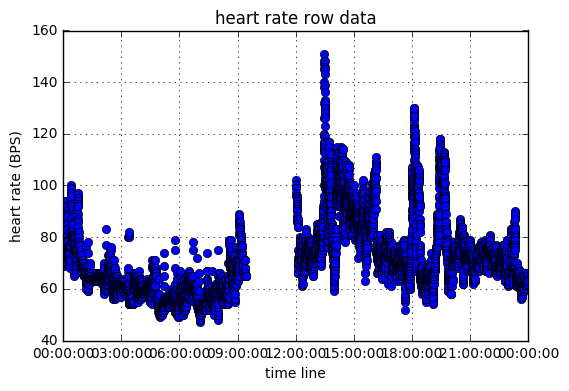

In [307]:
## show plot interactive, if you want inline, comment out this line.


def ploting(xvals, yvals, xlabel_str, ylabel_str, title, style):
    """
    creates a plot
    """
    # close all old plots
    plt.close("all")
    # plotting
    plt.plot(xvals, yvals, style)
    plt.xlabel(xlabel_str)
    plt.ylabel(ylabel_str)    
    plt.title(title)
    # show the grid line/ help line in plot
    plt.grid(True)
    #plt.legend(loc='upper right')
    #plt.axis([0, 210, 0, 0.04 ])
    #plt.figure(figsize=[9,6])
    plt.show()
   
## Main activity and time

xlabel_str = "time line"
ylabel_str = "heart rate (BPS)"
title = "heart rate row data"

# shows a point plot
ploting(timestampRaw,hrRaw, xlabel_str, ylabel_str, title, 'bo')


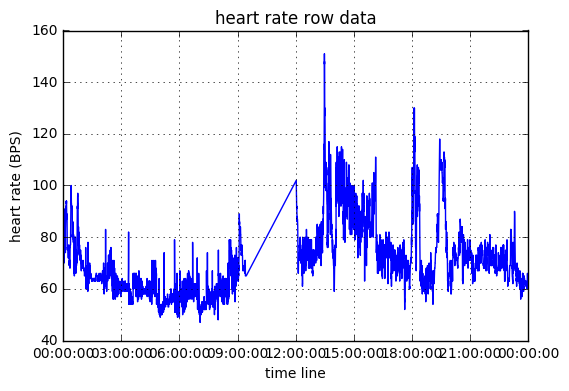

In [308]:
# shows a line plot
ploting(timestampRaw,hrRaw, xlabel_str, ylabel_str, title, 'b-')

In [12]:
plt.close('all')

## Segmenting the heart rate raw data
* segments heart rate raw data to 10 minutes segments
* for each segments, the heart rate feature is calculated.

In [13]:
def getBeginTimestamp(datetime):
    """
    this method returns the timestampe of the day by the given datetime.
    If the given datetime is 2016-10-05 01:29:20
    this method returns the timestamp of 2016-10-05 00:00:00
    """
    # extract the date string from the given datetime object
    str_current_date = dt.datetime.strftime(datetime, '%Y-%m-%d')
    # print("Current Observed Date: ",str_current_date)
    # convert the extracted date string to datetime object
    currentDate = dt.datetime.strptime(str_current_date, '%Y-%m-%d')
    # get the utc timestamp of the date string of the given datetime object
    int_ts_currentDate = int(dt.datetime.timestamp(currentDate))
    return int_ts_currentDate;

#current date timestamp
curDateTS = getBeginTimestamp(timestampRaw[0]) 
print("timestamp of current Date: " , curDateTS)

# list of timestamps saved in int
intTimestampRaw = [int(int(timestamp)/1000) for timestamp, heartRate in hrContent]

def segmentingDate(intTimestampRaw, hrRaw, curDateTS): 
    """
    this method make 10 minutes segments from heart rate raw data
    """
    segments = {}
    deliminator = 10 * 60
    segment_id = 0
    for id in range(len(intTimestampRaw)):
        timestamp = intTimestampRaw[id]
        heartrate = int(hrRaw[id])
        segment_id = (timestamp - curDateTS) // deliminator
        segment_label = segment_id * deliminator + curDateTS
        segments.setdefault(segment_label,[]).append(heartrate)
    return segments
# segments is a dictionary with segment timestamp as key, 
# and all heart rate values of the segment is saved as value
# in the segment dictionary
segments = segmentingDate(intTimestampRaw, hrRaw, curDateTS)
segments_labels = []
for label in segments.keys():
    segments_labels.append(int(label))
# in place sorting
list.sort(segments_labels)     
    
print("The number of segments is: ", len(segments))




timestamp of current Date:  1477519200
The number of segments is:  130


## Examing a sample segment
plots a sample segment

ploting segement with label:  2016-10-27 14:10:00


<IPython.core.display.Javascript object>


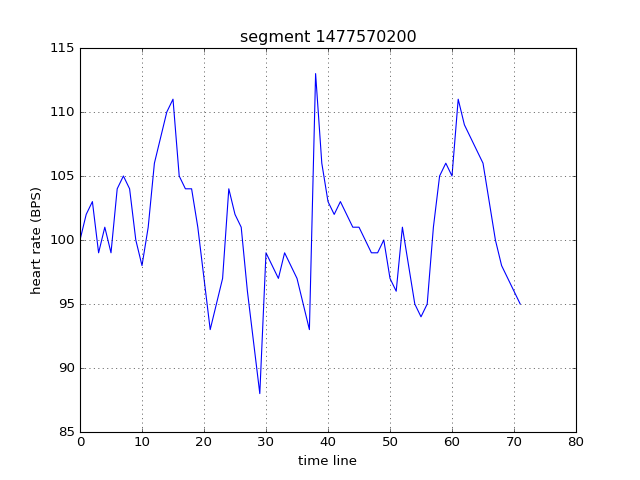

In [37]:
# Display segments

def displaySegment(idx):
    segment_label = segments_labels[idx]
    print("ploting segement with label: ", dt.datetime.fromtimestamp(segment_label))
    segment = segments[segment_label]
    # print(segment)
    ploting(range(len(segment)),segment, xlabel_str, ylabel_str, "segment "+ str(segment_label), 'b-')

displaySegment(70)

In [15]:
## Ein Segment zuviel!?!?
dt.datetime.fromtimestamp(segments_labels[-1])

datetime.datetime(2016, 10, 28, 0, 0)

## Example of featureCalculation function
the following featureCalculation function calculates the meanHR feature

* meanHR: the mean of the heart rate within a segment

Note: 

The following meanHR plot shall be very similar to the stila portal's heart rate plot, since the stila portal's plot does the mean aggregation of heart rates automatically while zooming. 

In [16]:

# this function calculates the heart rate value within a segment
# the type of heart rate value within the segment is integer
def featureCalculation(segment):
    return sum(segment)/len(segment)

<IPython.core.display.Javascript object>


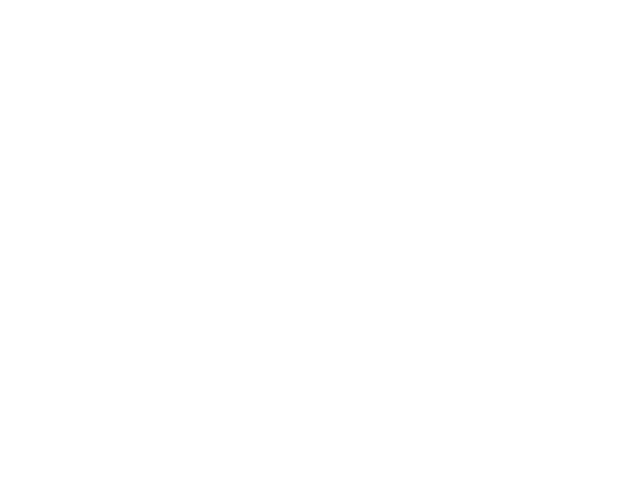

In [17]:
# enable matplotlib inline codes

# Ploting the segments
featureName = "meanHR"
title = "meanHR  to datetime"
featureValues = [featureCalculation(segments[segment_label]) for segment_label in segments_labels]
labelValues = [dt.datetime.fromtimestamp(segment_label) for segment_label in segments_labels]
ploting(labelValues, featureValues, 'datetime', featureName, title, 'g-')

## This meanHR plot shall be very similar 
## to the stila portal's heart rate plot

## Assignment 2 (featureCalculation function)
You shall modify the following featureCalculation function to calculate your assigned heart rate feature


In [18]:
# template function, adapt it to your heart rate feature
# this function calculates meanRR
# RR = 60/HR
# meanRR should display a reverse line plot to meanHR line plot

def featureCalculation(segment):
    return sum([60/value for value in segment])/len(segment)

## Assignment 3 (plotting features)
You shall only modify
* the name of your feature
* title of the plot

In [19]:
# Ploting the segments
featureName = "meanRR"
title = "meanRR  to datetime"

<IPython.core.display.Javascript object>


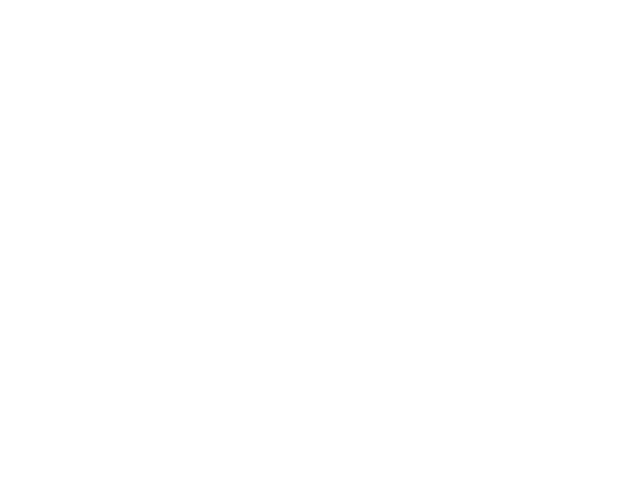

In [20]:
## You don't need to change this section for complete the assigment
featureValues = [featureCalculation(segments[segment_label]) for segment_label in segments_labels]
labelValues = [dt.datetime.fromtimestamp(segment_label) for segment_label in segments_labels]
ploting(labelValues, featureValues, 'datetime', featureName, title, 'y-')

# SDRR
Von Christian Lemke

## recap

### Normal distribution (Normal- oder Gauß-Verteilung) (nach Carl Friedrich Gauß)



The probability density of the normal distribution is:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/6404a4c69c536278a5933085f0d5f4a9ca9f2b2a">

$\mu$ (mu) is mean or expectation of the distribution (and also its median and mode).

$\sigma$ (sigma) is standard deviation

$\sigma ^{2}$ is variance

In [68]:
# in python (example from book)
import math
def normal_pdf(x, mu=0, sigma=1):
    sqrt_to_pi = math.sqrt(2 * math.pi)
    return (math.exp(-(x-mu) ** 2 / 2 / sigma ** 2) / (sqrt_to_pi * sigma))

In [69]:
# plot
xs = [x/10.0 for x in range(-50,50)]
plt.plot(xs, [normal_pdf(x) for x in xs], '-', label='mu=0,sigma=1')
plt.plot(xs, [normal_pdf(x,sigma=2) for x in xs], '-', label='mu=0,sigma=2')
plt.plot(xs, [normal_pdf(x,sigma=0.5) for x in xs], '-', label='mu=0,sigma=0.5')
plt.plot(xs, [normal_pdf(x,mu=-1) for x in xs], '-', label='mu=-1,sigma=1')
plt.legend()
plt.title('Various Normal pdfs')
plt.show()

### a recap: standard deviation

## Wiki: standard deviation
In statistics, the standard deviation (SD, also represented by the Greek letter sigma σ or the Latin letter s) is a measure that is used to quantify the amount of variation or dispersion of a set of data values.[1] A low standard deviation indicates that the data points tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the data points are spread out over a wider range of values.

## Simple Example

In [23]:
# import numpy as np (first cell)

# https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html

mean:  0.0
std: 0.456435464588


<IPython.core.display.Javascript object>


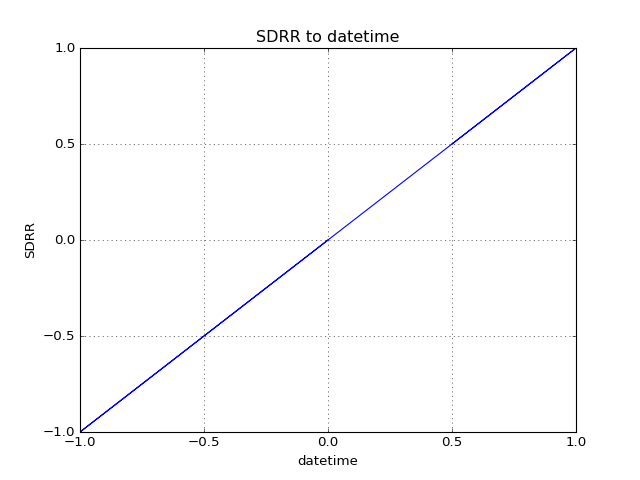

In [70]:
# sd Bsp:

bspValues = [0,0,0,0,0,0,0,0,-1,-0.5,1,0.5]

print( 'mean: ', sum(bspValues)/len(bspValues))
print ('std:', np.std(bspValues))
ploting(bspValues, bspValues, 'datetime', featureName, title, 'b-')


### Own Data

In [25]:
# Ploting the segments
featureName = "SDRR"
title = "SDRR to datetime"

In [156]:
def featureCalculation_RR(segment):
    return [60/hrValue for hrValue in segment]

def featureCalculation_SDRR(segment):
    """
    Takes a Segment of hrValues
    Transforms them to rrValues
    Calculates the standard deviation
    """
    return np.std([rrValues for rrValues in featureCalculation_RR(segment)])

def featureCalculation_MeanRR(segment):
    """
    Takes a Segment of hrValues
    Transforms them to rrValues
    Calculates the standard deviation
    """
    return sum([value for value in featureCalculation_RR(segment)])/len(segment)

In [27]:
# compute

featureValues = [featureCalculation_SDRR(segments[segment_label]) for segment_label in segments_labels]
labelValues = [dt.datetime.fromtimestamp(segment_label) for segment_label in segments_labels]

In [28]:
print( len(featureValues), len(labelValues))

130 130


<IPython.core.display.Javascript object>


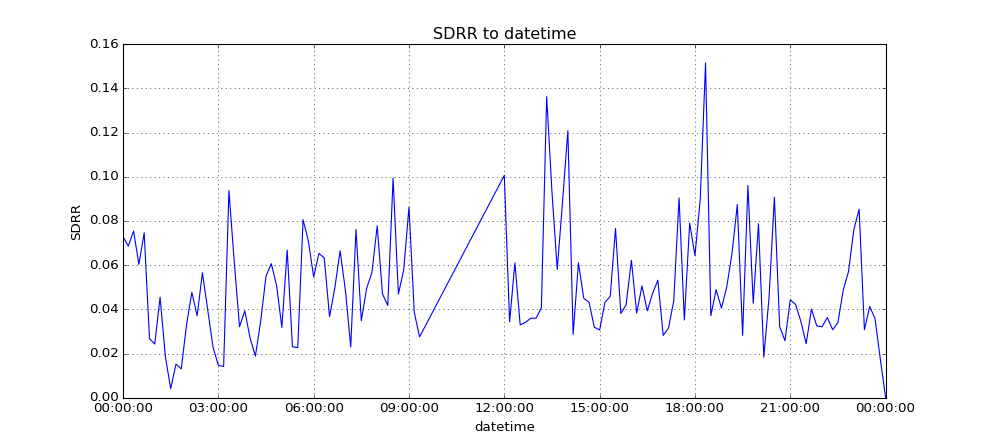

In [44]:
# plot all
ploting(labelValues, featureValues, 'datetime', featureName, title, 'b-')

In [207]:
# plot exam time span
# time span: exam + lecture 
#timeSpan1Start = 66
timeSpan1Start = 57
#timeSpan1End = 81
timeSpan1End = 100

print ('from', labelValues[timeSpan1Start], 'to', labelValues[timeSpan1End])


from 2016-10-27 12:00:00 to 2016-10-27 19:10:00


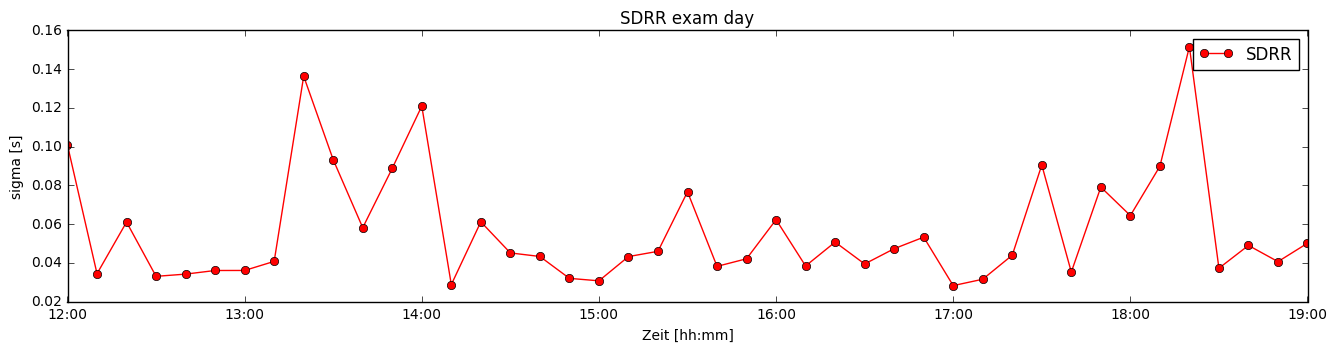

In [385]:

featureValues2 = [featureCalculation_SDRR(segments[segment_label]) for segment_label in segments_labels[timeSpan1Start:timeSpan1End]]
labelValues2 = [dt.datetime.fromtimestamp(segment_label) for segment_label in segments_labels[timeSpan1Start:timeSpan1End]]

from matplotlib.dates import DateFormatter

# plot
%matplotlib inline

fig, ax = plt.subplots()
fig.set_size_inches(16,3.5)
ax.plot_date(labelValues2, featureValues2, 'ro-', label='SDRR')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel('Zeit [hh:mm]')
plt.ylabel('sigma [s]')
plt.title('SDRR exam day')
plt.show()

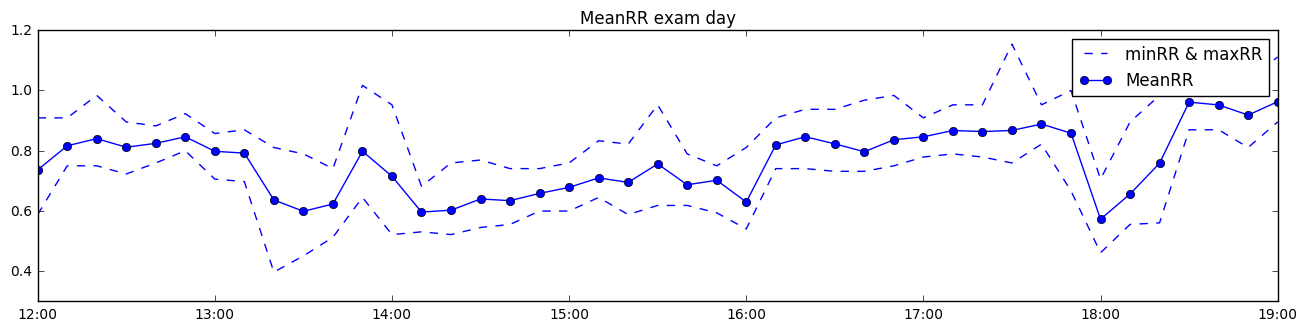

In [379]:
# plot exam time span
# time span: exam + lecture 

labelRange = segments_labels[timeSpan1Start:timeSpan1End]

featureValues22mean = [featureCalculation_MeanRR(segments[segment_label]) for segment_label in labelRange]

labelValues22 = [dt.datetime.fromtimestamp(segment_label) for segment_label in labelRange]



labelValues22max = [60/np.max(segments[segment_label]) for segment_label in labelRange]

labelValues22min = [60/np.min(segments[segment_label]) for segment_label in labelRange]


from matplotlib.dates import DateFormatter
# plot
%matplotlib inline

fig, ax = plt.subplots()
fig.set_size_inches(16,3.5)

ax.plot_date(labelValues22, labelValues22max, 'b--', label='minRR & maxRR')
ax.plot_date(labelValues22, featureValues22mean, 'bo-', label='MeanRR')
ax.plot_date(labelValues22, labelValues22min, 'b--')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

myFmt = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(myFmt)
plt.title('MeanRR exam day')

plt.show()

In [351]:
np.max(labelValues22min)

1.1538461538461537

In [354]:
# exam statistics
timeSpan2Start = 70
timeSpan2End = 80

allArray = []
allArrayRR = []

[[allArray.append(val) for val in (segments[segment_label])] for segment_label in segments_labels[timeSpan2Start:timeSpan2End]]
[allArrayRR.append(featureCalculation_RR(segments[segment_label])) for segment_label in segments_labels[timeSpan2Start:timeSpan2End]]



print ('from', labelValues[timeSpan2Start] , 'to',  labelValues[timeSpan2End])

maxbpm=np.max([np.max(segments[segment_label]) for segment_label in labelRange])
minbpm=np.min([np.max(segments[segment_label]) for segment_label in labelRange])
print ('max BPM: ', maxbpm, ', min BPM: ',minbpm)

maxRR=np.max([np.max(val) for val in allArrayRR])
minRR=np.min([np.min(val) for val in allArrayRR])
print ('min RR: ', minRR, ', max RR: ',maxRR)

from 2016-10-27 14:10:00 to 2016-10-27 15:50:00
max BPM:  151 , min BPM:  67
min RR:  0.521739130435 , max RR:  0.952380952381


In [306]:
[segments[segment_label] for segment_label in segments_labels[timeSpan2Start:timeSpan2End]]

[[100,
  102,
  103,
  99,
  101,
  99,
  104,
  105,
  104,
  100,
  98,
  101,
  106,
  108,
  110,
  111,
  105,
  104,
  104,
  101,
  97,
  93,
  95,
  97,
  104,
  102,
  101,
  96,
  92,
  88,
  99,
  98,
  97,
  99,
  98,
  97,
  95,
  93,
  113,
  106,
  103,
  102,
  103,
  102,
  101,
  101,
  100,
  99,
  99,
  100,
  97,
  96,
  101,
  98,
  95,
  94,
  95,
  101,
  105,
  106,
  105,
  111,
  109,
  108,
  107,
  106,
  103,
  100,
  98,
  97,
  96,
  95],
 [95,
  93,
  92,
  113,
  112,
  108,
  107,
  106,
  100,
  101,
  96,
  104,
  104,
  115,
  114,
  111,
  111,
  105,
  108,
  109,
  110,
  112,
  110,
  109,
  100,
  106,
  97,
  112,
  109,
  108,
  110,
  106,
  109,
  114,
  114,
  108,
  107,
  105,
  103,
  104,
  103,
  101,
  102,
  101,
  93,
  97,
  101,
  96,
  93,
  87,
  86,
  85,
  90,
  89,
  88,
  86,
  83,
  80,
  79,
  85,
  88,
  85,
  87,
  105,
  101,
  96,
  98,
  93],
 [91,
  93,
  100,
  103,
  101,
  110,
  102,
  104,
  101,
  98,
  95,
 